In [1]:

#dockerfile test edit
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.types import StructType, StructField, StringType, LongType, IntegerType
import sparknlp
spark = sparknlp.start() 
# sparknlp.start(gpu=True) >> for training on GPU
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
from langdetect import detect
from pyspark.sql.functions import col,udf, lit, concat_ws
from pyspark.sql.types import FloatType

from sklearn.metrics import classification_report
import requests
from warcio import ArchiveIterator
from bs4 import BeautifulSoup
import time
import pandas as pd
import re
import yfinance as yf
import boto3
import random
import sys 
import numpy as np
import os
import itertools
#PARAMETERS
path_dl_model = './models/model_dl'
batch_size_max = sys.maxsize -1
num_records_percrawl = 100#int(os.environ['NUMRECORDS']) #number of recors to attempt to extract from each crawl
ticker = 'SPY'

skiprecords = 300 #number of records to skip from the beginning of each crawl

number_warcs_to_analyze = 600 #int(os.environ['NUMWARCS']) #number of warcs to perform sentiment analysis on, goes from most reccent to farther back onse
randomsample = 'n' #str(os.environ['RANSAMPLE']).lower() #Y or N, if Y, then it will take a random sample of warcs to analyze, if N, it will take the most recent warcs

document_assembler = DocumentAssembler() \
    .setInputCol('text') \
    .setOutputCol('document')

sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer() \
    .setInputCols(['sentence']) \
    .setOutputCol('token')

lemmatizer = Lemmatizer()\
    .setInputCols(['token'])\
    .setOutputCol('lemma')\
  .setDictionary("./sentdat/lemmas_small.txt", key_delimiter="->", value_delimiter="\t")
SentimentDetector = sentiment.SentimentDetector() \
    .setInputCols(['lemma', 'sentence'])\
    .setOutputCol('sentiment_score')\
    .setDictionary('./sentdat/sentiment-big.csv', ',')\

pipeline = Pipeline(stages=[
    document_assembler, 
    sentence_detector,
    tokenizer,
    lemmatizer,
    SentimentDetector
])


s3 = boto3.resource('s3')
my_bucket = s3.Bucket('commoncrawl')
warcs = []
for object in my_bucket.objects.filter(Prefix='crawl-data/CC-NEWS/'):
    if object.key.endswith('.warc.gz'):
        warcs.append(object.key)

if randomsample == 'y':
    warcs = random.sample(warcs, number_warcs_to_analyze)
else:
  warcs = warcs[-number_warcs_to_analyze:]

for index, warc in enumerate(warcs):
    warcs[index] = 'https://data.commoncrawl.org/' + warc


path_dl_model = './models/model_dl'
print('starting to load model')
FINDMODEL = PipelineModel.load(path_dl_model)
print('model loaded')

def drop_nonfinance_articles(df):
  df = FINDMODEL.transform(df)
  df = df.withColumn('finance', df['financial_model_pred.result'].getItem(0).cast('float'))
  df = df.filter(df['finance'] == 1.0)
  return df


#function to convert time from commoncrawl format to y-m-d
def convert_header_date(date):
    return time.strftime('%Y-%m-%d', time.strptime(date, '%Y-%m-%dT%H:%M:%SZ'))


#obtaining stock data from yahoo finance from 2019 to current date.
currentdate = time.strftime("%Y-%m-%d")
stockdata = yf.download(ticker, start='2010-01-01', end=currentdate)['Adj Close']

#function to see if dates are earlier than 2023-04-24
def date_check(date):
    if date >= '2023-02-14' and date <= '2023-04-15':
        return True
    else:
        return False

your 131072x1 screen size is bogus. expect trouble


23/05/08 20:51:41 WARN Utils: Your hostname, DESKTOP-QC3P089 resolves to a loopback address: 127.0.1.1; using 172.18.70.79 instead (on interface eth0)
23/05/08 20:51:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/home/johan/am111/am111_venv/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/johan/.ivy2/cache
The jars for the packages stored in: /home/johan/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-ed417b1a-5970-4af4-a74e-ca8dd8cda0a1;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;4.2.4 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.15.0 in central
	found com.google.guava#guava;31.1-jre in central
	found com.google.guava#failurea

23/05/08 20:51:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


starting to load model


2023-05-08 20:52:06.767839: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


model loaded
[*********************100%***********************]  1 of 1 completed


In [3]:

# creating the main rdd to store the data
#creating scehma to store text and prices
data = StructType([\
  StructField("text", StringType(), True),
    StructField("price", StringType(), True),
    StructField("date", StringType(), True),
    StructField("url", StringType(), True)  
]
)

list_of_rows_batch = []
rows_batch_len = 0
recordsfetched = 0
failures = 0
total = 0 

for warc_url in warcs:
    response = requests.get(warc_url, stream=True)
    if response.ok!=True:
        continue
    records = ArchiveIterator(response.raw, arc2warc=True)
    records = itertools.islice(records, skiprecords, None)
    #what this should do is write each record's plaintexxt to a csv file
    for record in records:
        if recordsfetched >= num_records_percrawl:
            total += recordsfetched
            recordsfetched = 0
            print("warc done")
            break
        if record.rec_type == 'response':
            try: 
                html = record.content_stream().read() .decode('utf-8')
                plaintext = BeautifulSoup(html, 'lxml').get_text()
                plaintext = re.sub(r'\s+', ' ', plaintext)
                plaintext = re.sub(r'[^a-zA-Z0-9\s]', '', plaintext).lower()

                #obtains plaintext from the html
                if detect(plaintext) == 'en' and len(plaintext) > 150:  #TODO add classifier here later to ensure its a financial article
                    date = record.rec_headers.get_header('WARC-Date')
                    date = convert_header_date(date)
                    # append the plaintext and price to the batch
                    if date_check(date) == False:
                        break
                    if date in stockdata.index:
                        list_of_rows_batch.append({'text':plaintext, 'price':float(stockdata[date]), 'date':date, 'url':record.rec_headers.get_header('WARC-Target-URI')})
                        recordsfetched += 1
                        rows_batch_len += 1
                    else:
                        print('date not in stockdata',date)
                        #likely a weekend or holiday, so we will just skip the entire warc
                        break
                else:
                    recordsfetched += 1                          
            except:
                recordsfetched += 1  # because if the entire warc file is not in english or wrong date, we still want to move on to the next one
                failures += 1
                #print("attempt record: ", record.rec_headers.get_header('WARC-Target-URI'), " failed")
                pass

    
df = spark.createDataFrame(list_of_rows_batch, data)
print("size of data: ", total)
print("done")
print("failures: ", failures)


/home/johan/am111/am111_venv/lib/python3.10/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
warc done
date not in stockdata 2023-04-15
date not in stockdata 2023-04-15
date not in stockdata 2023-04-15
date not in stockdata 2023-04-15
date not in stockdata 2023-04-15
date not in stockdata 2023-04-15
date not in stockdata 2023-04-15
date not in stockdata 2023-04-15
date not in stockdata 2023-04-15
date not in stockdata 2023-04-15
date not in stockdata 2023-04-15
date not in stockdata 2023-04-15
date not in stockdata 2023-04-15
date not in stockdata 2023-04-15
date not in stockdata 2023-04-15
date not in stockdata 2023-04-15
date not in stockdata 

In [4]:
#sort out the finance articles
df.write.parquet('./df_12.parquet')
df = drop_nonfinance_articles(df)
#convert pyspark dataframe to pandas dataframe for plotting, note that this is not scalable
df = pipeline.fit(df).transform(df)
df = df.withColumn("sentiment_score", concat_ws(",", "sentiment_score.result"))
#drop all columns except sentiment_score and price, and date and url
df = df.drop('normalized','document', 'sentence', 'token', 'lemma', 'cleanTokens', 'embeddings', 'sentence_embeddings', 'financial_model_pred', 'text')

23/05/09 08:13:02 WARN TaskSetManager: Stage 25 contains a task of very large size (6740 KiB). The maximum recommended task size is 1000 KiB.


In [5]:
#NOT NESSECARY UNLESS SAVING PROGRESS FOR TESTIG PURPOSES
df.write.parquet('./df_12sorted.parquet')


23/05/09 08:13:07 WARN TaskSetManager: Stage 26 contains a task of very large size (6740 KiB). The maximum recommended task size is 1000 KiB.


In [35]:
#union df and df2
df = spark.read.parquet('./df_12sorted.parquet')
df2 = spark.read.parquet('./df_11sorted.parquet')
df = df.union(df2)
df.write.parquet('./df_13sorted.parquet')

/tmp/ipykernel_13401/511690288.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = df.groupby('date').mean()


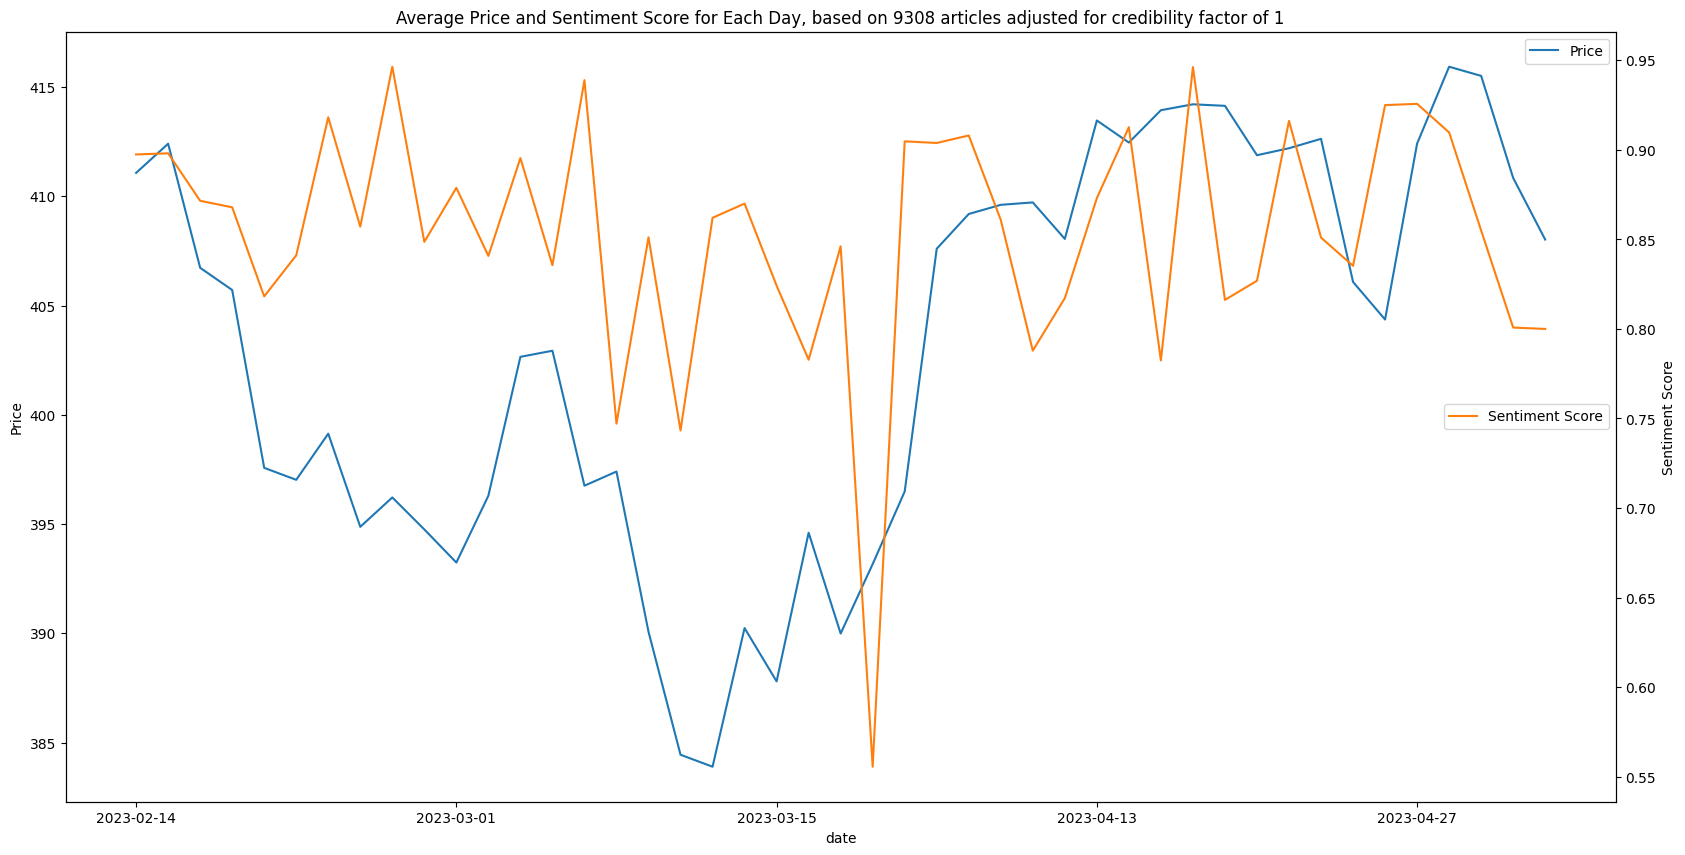

In [36]:
df = pd.read_parquet('./df_13sorted.parquet')

#replace all "positive" with 1 and "negative" with -1
df['sentiment_score'] = df['sentiment_score'].apply(lambda x: 1 if x == 'positive' else -1)
#convert sentiment_score column to int
df['sentiment_score'] = df['sentiment_score'].astype(int)
df['price'] = df['price'].astype(float)
df['url' ] = df['url'].astype(str)
#graph the avg sentiment score for each day, and the price of the stock for each day

#for each url in url column that has the words york times, bloomberg, or reuters, forbes, wsj, or cnbc, or cnn, fortune, business insider multiply by 10
# Function to check if any of the specified words are in the URL
sentimentadjust = 1
def update_sentiment_score(row):
    importantnews = 0
    keywords = ['nytimes', 'bloomberg', 'reuters', 'forbes', 'wsj', 'cnbc', 'cnn', 'fortune', 'business insider','nasdaq']
    url_lower = row['url'].lower()
    if any(keyword.lower() in url_lower for keyword in keywords):
        row['sentiment_score'] *= sentimentadjust
        importantnews += 1
        #print("adjusted")
    #print("important news: ", importantnews)
    return row


# Apply the function to the DataFrame
df = df.apply(update_sentiment_score, axis=1)


# Group by date and calculate the mean of price and sentiment_score
mean_df = df.groupby('date').mean()

# Plot both columns on the same plot
ax = mean_df.plot(y='price', use_index=True, figsize=(20, 10), title=f'Average Price and Sentiment Score for Each Day, based on {len(df)} articles adjusted for credibility factor of {sentimentadjust}')
mean_df.plot(y='sentiment_score', use_index=True, figsize=(20, 10), secondary_y=True, ax=ax)

ax.set_ylabel("Price")
ax.right_ax.set_ylabel("Sentiment Score")
ax.legend(["Price"])
ax.right_ax.legend(["Sentiment Score"], loc="center right")



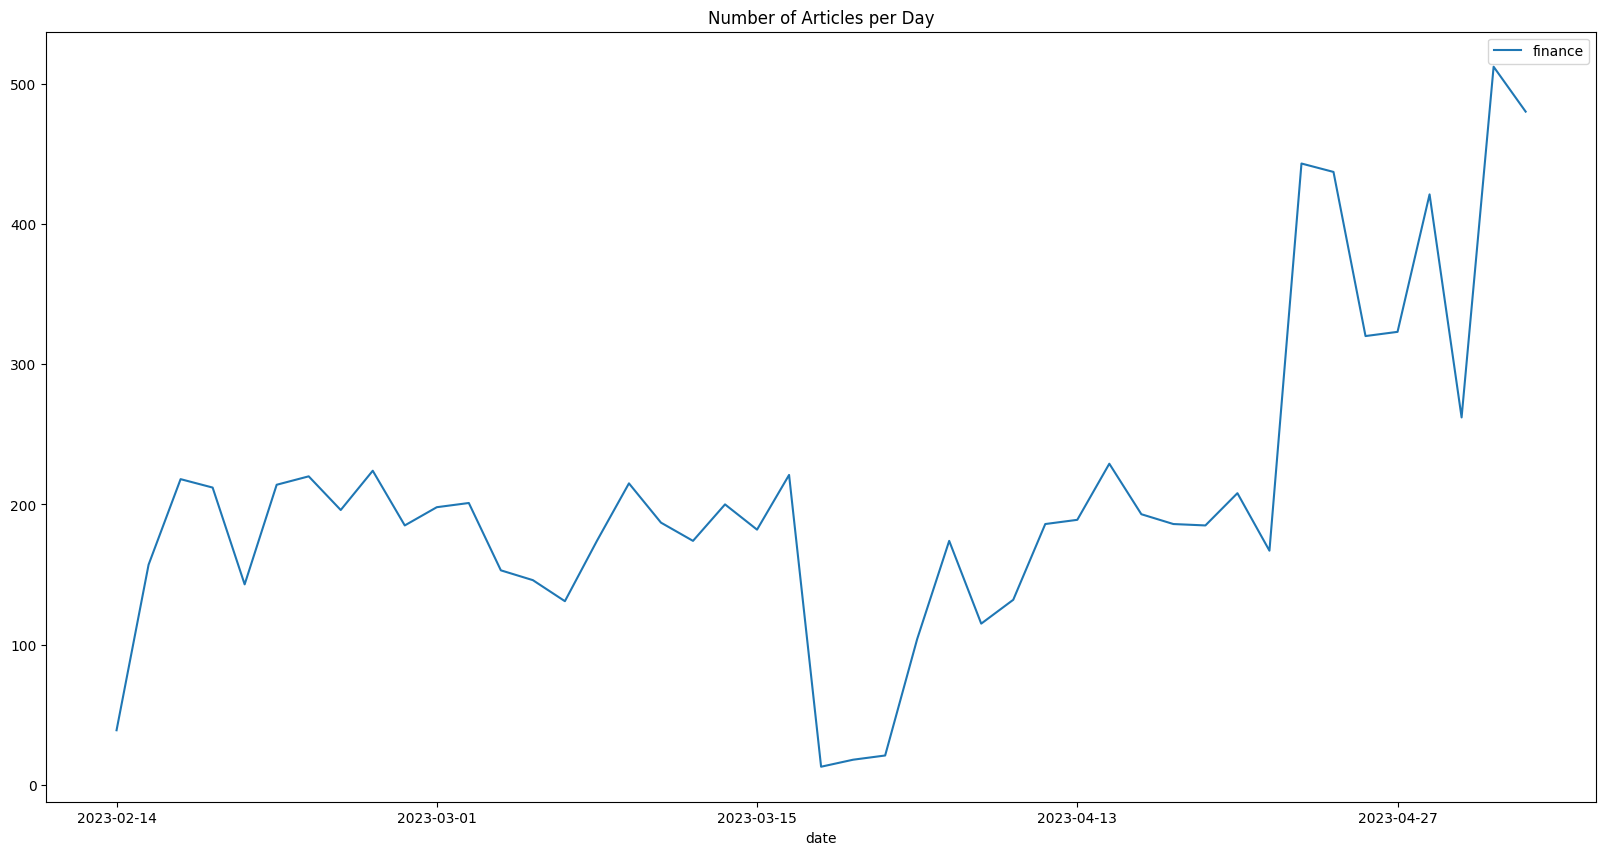

In [37]:
#count datapoints per date and plot
count_df = df.groupby('date').count()

ax = count_df.plot(y='finance', use_index=True, figsize=(20, 10), title=f'Number of Articles per Day')

In [6]:
#save the avg sentiment score and price for each day to a csv file

mean_df.to_csv('./mean_df_7.csv')
count_df.to_csv('./count_df_7.csv')



In [38]:
#find correlation between sentiment score and price
corr = df['sentiment_score'].corr(df['price'])
print("correlation: ", corr)
#find correlation between sentiment score and price on the next day
df['price_next_day'] = df['price'].shift(-1)
corr = df['sentiment_score'].corr(df['price_next_day'])
print("correlation next day: ", corr)


correlation:  0.019743843176413176
correlation next day:  0.020621677623847243


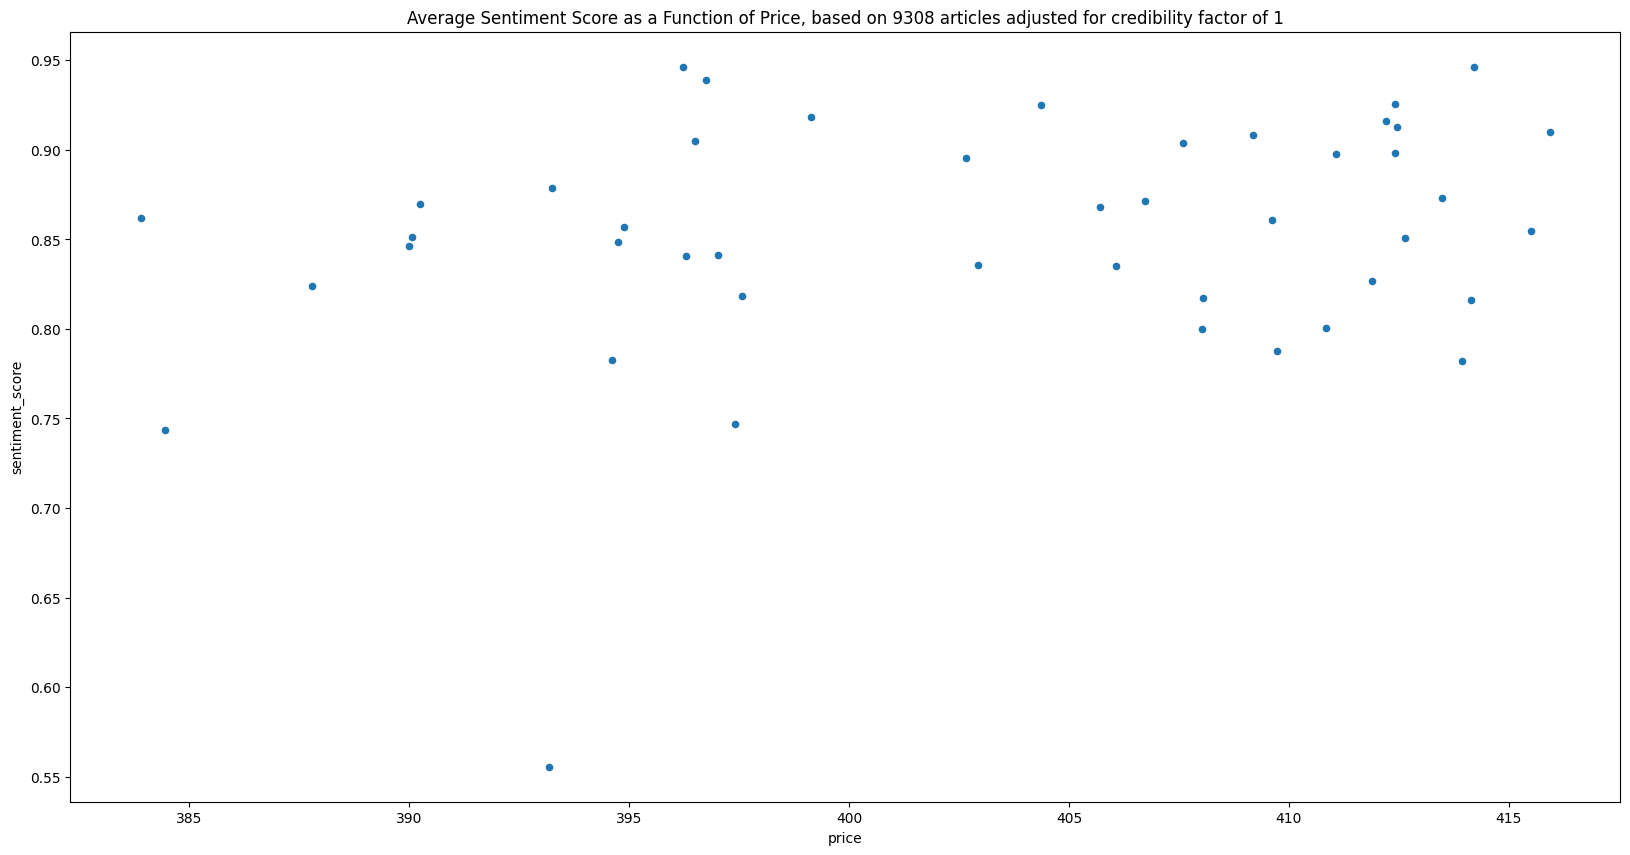

In [39]:
#graph the avg sentiment as a function of the price using mean_df
ax = mean_df.plot.scatter(x='price', y='sentiment_score', figsize=(20, 10), title=f'Average Sentiment Score as a Function of Price, based on {len(df)} articles adjusted for credibility factor of {sentimentadjust}')


In [24]:
#read in pands df_sorted
df = pd.read_parquet('./df_7sorted.parquet')
len(df)

4753